In [14]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
from nltk.corpus import stopwords
import string
import numpy as np
import nltk
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cross_validation import train_test_split
from nltk.classify.scikitlearn import SklearnClassifier
import unicodedata 
from sklearn.feature_selection.univariate_selection import SelectKBest, chi2

from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud 
from nltk.corpus import stopwords


In [9]:
#import data 

df = pd.read_csv("train.tsv",sep='\t' , encoding='utf-8' )
df_test =  pd.read_csv("test.tsv",sep='\t' , encoding='utf-8' )
df.drop(["PhraseId","SentenceId"],axis=1,inplace=True) # remove useless columns
df_test.drop(["PhraseId","SentenceId"],axis=1,inplace=True) # remove useless columns
df.head()
df.shape

(156060, 2)

In [18]:
df.Sentiment.unique()

array([1, 2, 3, 4, 0])

In [20]:
df

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2
5,of escapades demonstrating the adage that what...,2
6,of,2
7,escapades demonstrating the adage that what is...,2
8,escapades,2
9,demonstrating the adage that what is good for ...,2


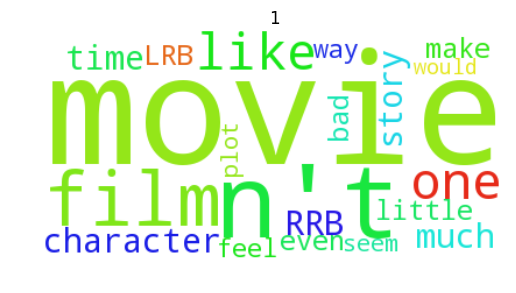

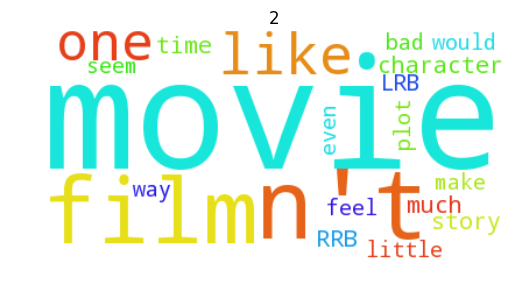

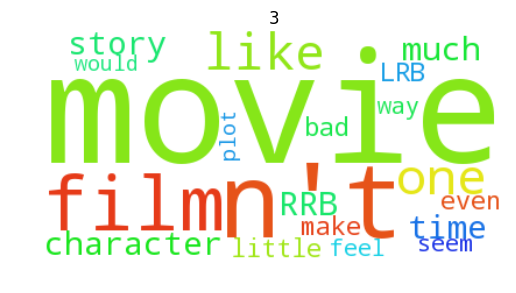

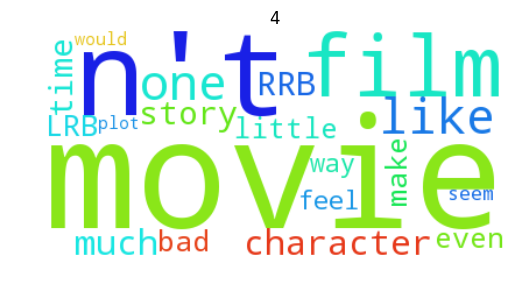

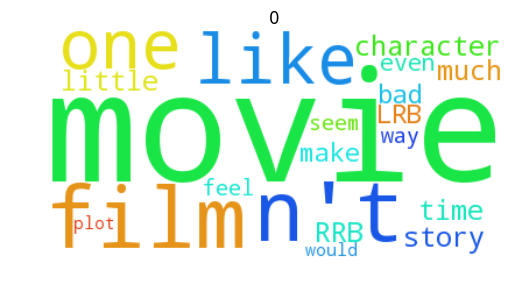

In [19]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
range = [1,2,3,4,0]
cloud = WordCloud(background_color="white", max_words=20, stopwords=stopwords.words('english'))
for i in range: 
    positive_cloud = cloud.generate(df.loc[df.Sentiment == 1, 'Phrase'].str.cat(sep='\n'))
    plt.figure()
    plt.imshow(positive_cloud)
    plt.axis("off")
    plt.title(i)
    plt.show()

In [47]:
# Transformer des caractères spéciaux en ASCII + maj to minuscules ( sorte de normalisation)


In [76]:

df['Phrase'] = (df['Phrase'].str.lower()
              .str.decode('utf-8')
              .map(lambda x: unicodedata.normalize('NFKD', x))
              .str.encode('ascii', 'ignore'))


 1) Remove punctuation marks and transform all characters to lowercase using nlk library 2) Remove stop words 3) Steaming

Sans oublier la segmentation afin de separer chaque phrase en mot l idée c que chaque mot dans une phrase va être consideré comme étant un feature
and finally tfidf

In [78]:
# remove punctionation
stemmer = PorterStemmer()
def remove_punctuation(s):
    s = ''.join([i for i in s if i not in set(string.punctuation)])
    return s

df['Phrase'] = df['Phrase'].apply(remove_punctuation)
#stemming
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [79]:
df['Phrase'] = df['Phrase'].apply(tokenize)

In [80]:
# we can improve it with changing parameters and add other parametrs 
# for example ngrams 
# max_df , min_df  and max_feature

stop = stopwords.words('english')
stop.extend(['will','now','today','movie','serie','series','story','film'])
df['Phrase'] = df['Phrase'].apply(lambda x: [item for item in x if item not in stop])

In [ ]:
import matplotlib.pyplot as plt
cloud = WordCloud(background_color="white", max_words=20, stopwords=stopwords)
tuples = tuple([tuple(x) for x in df.Phrase.value_counts().reset_index().values])
a = cloud.generate_from_frequencies(tuples)

plt.imshow(a)
plt.axis("off")
plt.title("a")
plt.show()

In [19]:
vect = TfidfVectorizer(min_df=5,sublinear_tf=True, analyzer='word', stop_words=stop, tokenizer=tokenize , strip_accents = 'ascii',  max_df = 0.8 )

In [42]:
X = vect.fit_transform(df.pop('Phrase'))

In [43]:
#sparse matrix to datframe here i used for becaus the memory of my computer does not suppert to transfor matrix to dataframe en un seul coup that why it take time 
for i, col in enumerate(vect.get_feature_names()):
    df[col] = pd.SparseSeries(X[:, i].toarray().reshape(-1,), fill_value=0)

In [44]:
df.shape

(156060, 11402)

In [72]:
for i, col in enumerate(vect.get_feature_names()):
    df_test[col] = pd.SparseSeries(X[:, i].toarray().reshape(-1,), fill_value=0)

In [38]:
print(df.isnull().values.sum().sum())


0


In [ ]:
df.head()

In [107]:
#validation for svm
#there are an error to check it ( grid search ne marche pas i will check why after)
label = df.Sentiment
train= df.drop('Sentiment', axis=1)


from sklearn.pipeline import Pipeline
text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                      ('clf', LinearSVC()),
 ])
from sklearn.model_selection import GridSearchCV
parameters = {'tfidf_min_df': [[0.8, 1.0], 1],
               'tfidf__max_df': ([0.8, 1.0], 1),
               'clf__c': (0.1, 1 , 10),
 }
gs_clf = GridSearchCV(text_clf, parameters)
gs_clf = gs_clf.fit(train.as_matrix(), label)





MemoryError: 

In [105]:
label = df['Sentiment'].values
train= df.drop('Sentiment', axis=1)
classif = SklearnClassifier(LinearSVC())
# Séparation du set de train et de test
X_train,X_test,y_train,y_test = train_test_split(train.as_matrix(),label, test_size = 0.33)


MemoryError: 

In [ ]:
#grid search to find the best parameters


In [ ]:
#pd.SparseDataFrame(X.todense(), columns=vect.get_feature_names(), index=df.index) 

In [253]:
#X = vect.fit_transform(df.pop('Phrase'))
#X = vect.fit_transform(df.pop('Phrase')).toarray()

#for i, col in enumerate(vect.get_feature_names()):
    #df[col] = X[:, i]

In [90]:
#r = df[['Sentiment']].copy()
#del df
#d = pd.DataFrame(X.toarray(), columns=vect.get_feature_names(), iterator=True, chunksize=10)

#d = pd.DataFrame(X, columns=vect.get_feature_names())
#del X
#del vect



In [91]:
#d.head()